<a href="https://colab.research.google.com/github/ShaunakSen/Data-Science-and-Machine-Learning/blob/master/SmartSteelTech_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rough Approach

1. EDA
    - Explore how distribution of class labels change wrt each sensor
    - Corr bw sensor data
2. Baseline LogReg model
    - explore performance
    - wts of the features correspond to the importances?
    - https://machinelearningmastery.com/calculate-feature-importance-with-python/

3. Decision Tree model
    - feature importances

4. Idea 
    - what if we use a tree with only one feature at a time and analyze the accuracy
    - This is how DTs are constructed, we decide on the root node by checking which feature predicts best - we can use this same approach

4. SHAP on that DT
    - Global Importances
    - Local Importances
    - if we have instances that are more imp to us, we can look that the
    - features which explain those instances and put more wt on these features; SHAP allows us to do this
    - Also imagine if our prob were unbalanced and there are few values of one class. Now one feature may only be imp in predictions of that class. The default FI calculates how many times a feature is used as a split and this no will be low for that feature, but its very imp for that class

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import itertools
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline

In [2]:
data = pd.read_csv(filepath_or_buffer='./task_data.csv')
data

,sample index,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
0,sample0,1.0,0.834251,0.726081,0.535904,0.214896,0.873788,0.767605,0.111308,0.557526,0.599650,0.665569
1,sample1,1.0,0.804059,0.253135,0.869867,0.334285,0.604075,0.494045,0.833575,0.194190,0.014966,0.802918
2,sample2,1.0,0.694404,0.595777,0.581294,0.799003,0.762857,0.651393,0.075905,0.007186,0.659633,0.831009
3,sample3,1.0,0.783690,0.038780,0.285043,0.627305,0.800620,0.486340,0.827723,0.339807,0.731343,0.892359
4,sample4,1.0,0.788835,0.174433,0.348770,0.938244,0.692065,0.377620,0.183760,0.616805,0.492899,0.930969
...,...,...,...,...,...,...,...,...,...,...,...,...
395,sample395,-1.0,0.433150,0.816109,0.452945,0.065469,0.237093,0.719321,0.577969,0.085598,0.357115,0.070060
396,sample396,-1.0,0.339346,0.914610,0.097827,0.077522,0.484140,0.690568,0.420054,0.482845,0.395148,0.438641
397,sample397,-1.0,0.320118,0.444951,0.401896,0.970993,0.960264,0.138345,0.354927,0.230749,0.204612,0.558889
398,sample398,-1.0,0.059132,0.337426,0.772847,0.099038,0.966042,0.975086,0.532891,0.035839,0.258723,0.709958


In [3]:
data.isnull().sum(axis=0)

sample index    0
class_label     0
sensor0         0
sensor1         0
sensor2         0
sensor3         0
sensor4         0
sensor5         0
sensor6         0
sensor7         0
sensor8         0
sensor9         0
dtype: int64

Good, so no NULL values

In [4]:
data.describe()

,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.000000,0.523661,0.509223,0.481238,0.509752,0.497875,0.501065,0.490480,0.482372,0.482822,0.541933
std,1.001252,0.268194,0.276878,0.287584,0.297712,0.288208,0.287634,0.289954,0.282714,0.296180,0.272490
min,-1.000000,0.007775,0.003865,0.004473,0.001466,0.000250,0.000425,0.000173,0.003322,0.003165,0.000452
25%,-1.000000,0.299792,0.283004,0.235544,0.262697,0.249369,0.269430,0.226687,0.242848,0.213626,0.321264
50%,0.000000,0.534906,0.507583,0.460241,0.510066,0.497842,0.497108,0.477341,0.463438,0.462251,0.578389
75%,1.000000,0.751887,0.727843,0.734937,0.768975,0.743401,0.738854,0.735304,0.732483,0.740542,0.768990
max,1.000000,0.999476,0.998680,0.992963,0.995119,0.999412,0.997367,0.997141,0.998230,0.996098,0.999465


All features are in rane 0 -> 1, so they are quite normalized

In [5]:
data['class_label'].value_counts()

-1.0    200
 1.0    200
Name: class_label, dtype: int64

This is a perfectly balanced binary classification scenario

## Analysis 1 : How does the distrubution of class label changes wrt each feature

- For each feature, how is the distribution of values for the class label
- pairwise boxplot with the 2 classes as 2 diff colors

In [6]:
def feature_distribution_per_class(data, features):
    """
    For each feature print out the distribution of that feature for each class
    """
    for fea_ in features:
        if fea_ in data.columns:
            display(data.groupby('class_label').aggregate({fea_: ['mean', min, max]} ))

    return

features = [f'sensor{i}' for i in range(10)]
feature_distribution_per_class(data, features)

sensor0                    
                 mean       min       max
class_label                              
-1.0         0.378135  0.007775  0.999476
 1.0         0.669187  0.017610  0.999476

sensor1                    
                 mean       min       max
class_label                              
-1.0         0.578911  0.004316  0.998680
 1.0         0.439535  0.003865  0.981556

sensor2                    
                 mean       min       max
class_label                              
-1.0         0.470101  0.004473  0.992963
 1.0         0.492376  0.013799  0.975777

sensor3                    
                 mean       min       max
class_label                              
-1.0         0.380815  0.001466  0.995119
 1.0         0.638689  0.014431  0.991156

sensor4                    
                 mean       min       max
class_label                              
-1.0         0.322972  0.000250  0.999412
 1.0         0.672778  0.002246  0.999412

sensor5                    
                 mean       min       max
class_label                              
-1.0         0.436673  0.000425  0.984338
 1.0         0.565457  0.002695  0.997367

sensor6                    
                 mean       min       max
class_label                              
-1.0         0.492627  0.248746  0.745404
 1.0         0.488333  0.000173  0.997141

sensor7                    
                 mean       min       max
class_label                              
-1.0         0.432786  0.003453  0.975558
 1.0         0.531957  0.003322  0.998230

sensor8                    
                 mean       min       max
class_label                              
-1.0         0.287406  0.003864  0.959601
 1.0         0.678239  0.003165  0.996098

sensor9                    
                 mean       min       max
class_label                              
-1.0         0.516104  0.007976  0.982287
 1.0         0.567762  0.000452  0.999465

At a glance there looks to be variability in all features for each class label

- For most features the avg value of that feature for class 1 is diffenet from that of class -1

- For sensor6, the mean is very similar, but again the min and max differ, so even this feature can be quite important

In [7]:
def plot_feature_distribution_per_class(data, features, ncols):
    """
    Plot the distribution for each feature wrt each label
    data: the input dataframe
    features: feature names to plot
    ncols: no of cols to use in the figure (rows get adjusted automatically)
    """
    fig, axes = plt.subplots(int(np.ceil(len(features)/ncols)), ncols, figsize=(25, 20))
    sns.set_context('paper')
    row_idx = -1
    for idx, fea_ in enumerate(features):
        if idx > ncols-1:
            col_idx = idx%ncols
        else:
            col_idx = idx
        if col_idx == 0:
            row_idx += 1
        sns.boxplot(ax=axes[row_idx, col_idx], x='class_label', y=fea_, data=data)
        axes[row_idx, col_idx].set_title(f'Distribution of {fea_} for each class label')

    return


plot_feature_distribution_per_class(data, features, 4)

- we can see from the plots as well that the distributions differ significantly within classes for each of the features
- from this, we conclude that __we cannot yet assume that any feature is not important__

## Analysis 2: Analyze correlations within features

- first we can generate plots taking 2 features at a time to understand how they are related to each other

- if the trend seems linear we can apply Person's correlation (we already know that each feature is numeric)

- Since there are 10 features we will have `10C2 = 45` possible combinations of features


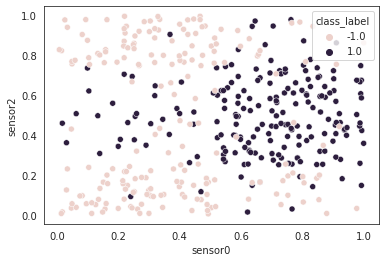

In [8]:
sns.set_style("white")
sns.scatterplot(x='sensor0', y='sensor2', hue='class_label', data=data);

In [9]:
def visualize_pairwise_feature_interactions(data, features, ncols):

    all_feature_combos = list(itertools.combinations(features,2))

    fig, axes = plt.subplots(int(np.ceil(len(all_feature_combos)/ncols)), ncols, figsize=(30, 60))
    sns.set_context('paper')
    row_idx = -1
    for idx, (fea_1, fea_2) in enumerate(all_feature_combos):
        if idx > ncols-1:
            col_idx = idx%ncols
        else:
            col_idx = idx
        if col_idx == 0:
            row_idx += 1
        sns.scatterplot(ax=axes[row_idx, col_idx], x=fea_1, y=fea_2, hue='class_label', data=data)
        axes[row_idx, col_idx].set_title(f'{fea_1} vs {fea_2}')

    return

visualize_pairwise_feature_interactions(data, features, 4)

We observe some interesting patterns from the above plot:

- there seems to be weak to no correlations between features

- by coloring the class labels we can identify how the class labels depend on the interaction of features

- In many cases there appears as if we can construct linear decision boundaries to determine each class label
    - For example:
    - In the sensor0 vs sensor6 plot we can draw decison boundaries as shown to separate out the 2 classes
    - ![](https://i.imgur.com/8IpdgV6.png)

    - we can roughly see that the approximate rule is: when `0 <= sensor6 < 0.2 OR 0.8 < sensor6 < 1 -> class 1 else class 0 `

    - The decision boundaries can look slightly more complex as shown below:
    - ![](https://i.imgur.com/EZHeNVp.png)
    - The boundary is just for illustration purpose and not a pratical one but we can see that based on various combinations of the features we can separate out the classes

    sensor2 > 0.2 and sensor2 <0.8 and sensor1 < 0.6 OR (sensor2 > 0.15 and )
    - These linear boundaries look very similar to the ones construced by Decision Trees and tree-based algorithm looks suitable for such a problem. Below are some example decision boundaries of DTs vs KNNs

    ![](https://shapeofdata.files.wordpress.com/2013/07/dtree2.png)

    ![](https://shapeofdata.files.wordpress.com/2013/03/knn1.png)

    Source: https://shapeofdata.wordpress.com/2013/07/02/decision-trees/

    - Also decision trees give us the ability to compute feature importances quite easily by computing the total information the feature provides while building the tree


## Approach 1: Using Decision Trees for each feature

1. Consider each feature as a stand-alone feature in the dataset
2. Construct a decision tree using that feature
3. Compute the accuracy (training accuracy) for the decision tree
    - this indicates how good that feature alone is in separating the classes
    - since we are dealing with a balance binary classification problem, accuracy is a suitable metric here
4. Rank the features based on this accuracy
5. the benefit of this approach is that we rank each feature individually without the influence/interactions with the other features


In [10]:
### convert the class labels to be 0 and 1 for compatiblity with sklearn
data['class_label'] = [1 if label_==1 else 0 for label_ in data['class_label']]

In [ ]:
data

,sample index,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
0,sample0,1,0.834251,0.726081,0.535904,0.214896,0.873788,0.767605,0.111308,0.557526,0.599650,0.665569
1,sample1,1,0.804059,0.253135,0.869867,0.334285,0.604075,0.494045,0.833575,0.194190,0.014966,0.802918
2,sample2,1,0.694404,0.595777,0.581294,0.799003,0.762857,0.651393,0.075905,0.007186,0.659633,0.831009
3,sample3,1,0.783690,0.038780,0.285043,0.627305,0.800620,0.486340,0.827723,0.339807,0.731343,0.892359
4,sample4,1,0.788835,0.174433,0.348770,0.938244,0.692065,0.377620,0.183760,0.616805,0.492899,0.930969
...,...,...,...,...,...,...,...,...,...,...,...,...
395,sample395,0,0.433150,0.816109,0.452945,0.065469,0.237093,0.719321,0.577969,0.085598,0.357115,0.070060
396,sample396,0,0.339346,0.914610,0.097827,0.077522,0.484140,0.690568,0.420054,0.482845,0.395148,0.438641
397,sample397,0,0.320118,0.444951,0.401896,0.970993,0.960264,0.138345,0.354927,0.230749,0.204612,0.558889
398,sample398,0,0.059132,0.337426,0.772847,0.099038,0.966042,0.975086,0.532891,0.035839,0.258723,0.709958


In [20]:
features = [f'sensor{i}' for i in range(10)]

X, y = data.loc[:, features], data['class_label']


In [25]:
def DT_for_each_feature(data, features):
    """
    """

    results_data = []

    for fea_ in features:
        print (f'Training DT for {fea_}')
        X, y = data.loc[:, [fea_]], data['class_label']
        clf = DecisionTreeClassifier(criterion='gini')
        clf.fit(X, y)
        ### get predictions on the training data
        y_pred = clf.predict(X)
        acc_ = accuracy_score(y_true=y, y_pred=y_pred)
        f1_ = f1_score(y_true=y, y_pred=y_pred)
        results_data.append({'feature': fea_, 'accuracy': acc_, 'f1_score': f1_})  
    return results_data

all_features = [f'sensor{i}' for i in range(10)]

results_data = DT_for_each_feature(data, features)



Training DT for sensor0
Training DT for sensor1
Training DT for sensor2
Training DT for sensor3
Training DT for sensor4
Training DT for sensor5
Training DT for sensor6
Training DT for sensor7
Training DT for sensor8
Training DT for sensor9


In [35]:
feature_rank_f1 = [item['feature'] for item in sorted(results_data, key=lambda res_: res_['f1_score'], reverse=True)]
feature_rank_acc = [item['feature'] for item in sorted(results_data, key=lambda res_: res_['accuracy'], reverse=True)]

print (feature_rank_f1)
print (feature_rank_acc)

print (feature_rank_acc == feature_rank_f1)

['sensor6', 'sensor1', 'sensor8', 'sensor2', 'sensor4', 'sensor5', 'sensor0', 'sensor7', 'sensor9', 'sensor3']
['sensor6', 'sensor1', 'sensor8', 'sensor2', 'sensor4', 'sensor5', 'sensor0', 'sensor7', 'sensor9', 'sensor3']
True


In [21]:
clf = DecisionTreeClassifier(max_depth=2)

In [22]:
clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [24]:
y_pred = clf.predict(X)

accuracy_score(y_true=y, y_pred=y_pred)

0.93

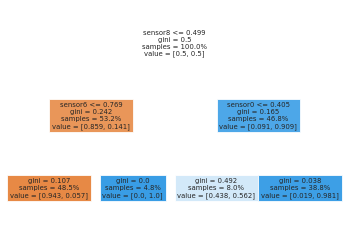

In [ ]:
plot_tree(clf, feature_names=list(X.columns), filled=True, proportion=True);

In [ ]:
features = [f'sensor{8}']

print (features)

X, y = data.loc[:, features], data['class_label']

print(X.shape, y.shape)

['sensor8']
(400, 1) (400,)


In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(20, 20), dpi=80)

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
plt.figure(figsize=(50,50))  # set plot size (denoted in inches)

plot_tree(clf, feature_names=list(X.columns), filled=True, proportion=True, fontsize=8);

sensor6 does an awesome job but if we restrict depth=1 it wont it needs dept = 2

In [12]:
y_true = [0,0,0,1,1,1]
y_pred = [1,1,0,1,1,1]
accuracy_score(y_true, y_pred)

0.6666666666666666

## Approach 2 : Use feature importance of DTs

In [37]:
all_features = [f'sensor{i}' for i in range(10)]
X, y = data.loc[:, all_features], data['class_label']

print (X.shape, y.shape)

(400, 10) (400,)


In [38]:
clf = DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [39]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [ ]:
plt.figure(figsize=(20,20))  # set plot size (denoted in inches)

plot_tree(clf, feature_names=list(X.columns), filled=True, proportion=True, fontsize=8);

In [42]:
y_pred = clf.predict(X)

print (accuracy_score(y_true=y, y_pred=y_pred), f1_score(y_true=y, y_pred=y_pred))

1.0 1.0


In [43]:
clf.feature_importances_

array([0.04797654, 0.0096791 , 0.        , 0.        , 0.00313982,
       0.00666667, 0.33649648, 0.00833333, 0.58770807, 0.        ])

In [49]:
feature_importance_indices = np.argsort(-clf.feature_importances_)

In [50]:
feature_rank_method2 = [all_features[idx] for idx in feature_importance_indices]

feature_rank_method2

['sensor8',
 'sensor6',
 'sensor0',
 'sensor1',
 'sensor7',
 'sensor5',
 'sensor4',
 'sensor2',
 'sensor3',
 'sensor9']

In [51]:
feature_rank_acc

['sensor6',
 'sensor1',
 'sensor8',
 'sensor2',
 'sensor4',
 'sensor5',
 'sensor0',
 'sensor7',
 'sensor9',
 'sensor3']

We do not really need to consider a test set here as the ML model is not to be deployed

We are just using it to rank features

In [54]:
clf.get_depth()

6